In [32]:
import cv2
import numpy as np
from PIL import Image
import IPython
import matplotlib.pyplot as plt

## write function that shows image in jupyter notebook
def display(img):
    pil_image = Image.fromarray(img)
    SCALE = 2
    width, height = pil_image.size
    pil_image = pil_image.resize((width*SCALE, height*SCALE), Image.NEAREST)
    IPython.display.display(pil_image)


256 192 3


/var/folders/kb/v8cc6x4n5ygftdb030ll4sq40000gn/T/ipykernel_53809/3992334537.py:12: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  pil_image = pil_image.resize((width*SCALE, height*SCALE), Image.NEAREST)


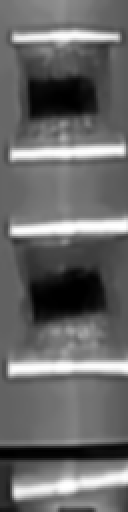

In [39]:
# Load video capture from file
cap = cv2.VideoCapture('output8.mp4')

# Grab first frame to get resolution
ret, frame = cap.read()
# flip image
frame = cv2.flip(frame, 0)

height, width, channels = frame.shape
print (height, width, channels)

# assure grayscale
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# apply gaussian blur
frame = cv2.GaussianBlur(frame, (5, 5), 0)


# crop only center third of the image as a stripe
frame = frame[:, width//3:2*width//3]

display(frame)


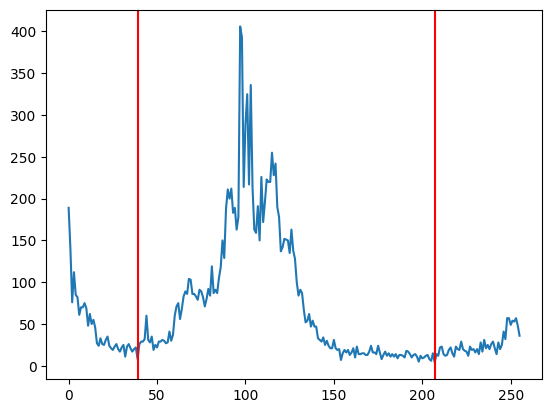

/var/folders/kb/v8cc6x4n5ygftdb030ll4sq40000gn/T/ipykernel_53809/3992334537.py:12: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  pil_image = pil_image.resize((width*SCALE, height*SCALE), Image.NEAREST)


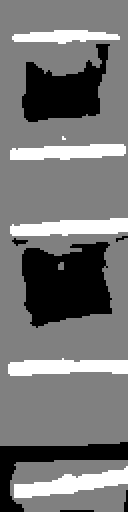

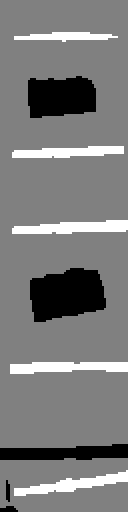

In [97]:

# segment using multiotsu
from skimage.filters import threshold_multiotsu

# apply multi otsu thresholding
thresholds = threshold_multiotsu(frame, classes=3)

def _create_threshold_masks(gray, thresholds):
    def _create_mask(region, morph_op=None, kernel=None):
        mask = np.zeros_like(region, dtype=np.uint8)
        mask[region] = 255
        if morph_op:
            pass
            #mask = cv2.morphologyEx(mask, morph_op, kernel)
        return mask
    region_cold = gray <= thresholds[0]
    region_mid = (gray > thresholds[0]) & (gray <= thresholds[1])
    region_hot = gray > thresholds[1]
    mask_cold = _create_mask(region_cold, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    mask_mid = _create_mask(region_mid)
    mask_hot = _create_mask(region_hot, cv2.MORPH_OPEN, np.ones((3, 11), np.uint8))
    return mask_cold, mask_mid, mask_hot

mask_cold, mask_mid, mask_hot = _create_threshold_masks(frame, thresholds)

debug_frame = np.zeros_like(frame)
debug_frame[mask_hot > 0] = 255
debug_frame[mask_mid > 0] = 128
debug_frame[mask_cold > 0] = 0
debug_frame = cv2.cvtColor(debug_frame, cv2.COLOR_GRAY2BGR)

# calculate histogram of frame and plot
hist = cv2.calcHist([frame],[0],None,[256],[0,256])

# find valley between cold and mid, and mid and hot
mid_peak = np.argmax(hist)
valley1 = np.argmin(hist[:mid_peak])
valley2 = np.argmin(hist[mid_peak:]) + mid_peak

# plot hist with valleys
plt.plot(hist)
plt.axvline(x=valley1, color='r')
plt.axvline(x=valley2, color='r')
plt.show()

# create second debug frame, where all pixels are either cold, mid or hot based on histogram valleys
debug_frame2 = np.zeros_like(frame)
debug_frame2[frame < valley1] = 0
debug_frame2[(frame >= valley1) & (frame < valley2)] = 128
debug_frame2[frame >= valley2] = 255
debug_frame2 = cv2.cvtColor(debug_frame2, cv2.COLOR_GRAY2BGR)

display(debug_frame)
display(debug_frame2)
